# bayes search parameter selection

In [1]:
# !python -m rpy2.situation

In [2]:
from pre_processing import remove_html_tags, preprocess_data, prepare_corpus
from post_processing import topic_selection
# from rpy2 import robjects #loading R inside Python
# #importing functions to read pandas DF
# from rpy2.robjects import pandas2ri
# pandas2ri.activate()
# from rpy2.robjects.packages import importr
# from rpy2.robjects.conversion import localconverter

import pandas as pd

import numpy as np

import os

#import R base library
# base = importr('base')

mallet_path = 'mallet' #'mallet for mac-os

[nltk_data] Downloading package stopwords to /home/amh418/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/amh418/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/amh418/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/amh418/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [3]:
stop_words = []

with open('freqPOS+Names.stop','r') as txtfile:
    for r in txtfile:
        stop_words.append(r.strip())
        if "'" in r:#add the term without "'"; e.g., haven't & havent
            stop_words.append(r.replace("'","").strip())

#adding the selected stop_words
stop_words.extend(['go','going','got','want','time','really','good','life','let','even','get',
                  'always','answer','back','day','feel','love','need','never','people',
                  'question','right','see','still','things','today','way','week'])

stop_words[10:15]

['duncan', 'fluffy', 'jack', 'jake', 'jim']

In [4]:
import mysql.connector

#connecting to DB
cnx = mysql.connector.connect(user='push', password='ElI)g!LDOBIwM)%*5o5{dbfz('
                              ,host='127.0.0.1',database='edml')

In [5]:
cursor = cnx.cursor() #making a cursor to execute a SQL command
# cursor.execute("select * from post") #execute a command
cursor.execute("select * from post where user_id != (select user_id from user where user_login='recoverwithmeda')") #execute a command
myresult = cursor.fetchall() #get all the results 
print('{0} posts were retreived'.format(len(myresult))) 

8341 posts were retreived


In [6]:
#loading user_id and user_name to convert id to user_name
cursor.execute("select * from user") #execute a command
users = cursor.fetchall() #get all the results 
users = {i[0]:i[1] for i in users}
myresult = [i[0:2] + tuple([users[i[2]]]) + i[3:] for i in myresult]

#concatenating the old dataset to the new one
myresult_ = [tuple(i[1:]) for i in pd.read_csv('./data/old_ed.csv',index_col=None).values]
myresult += myresult_
print('{0} posts were retreived'.format(len(myresult))) 

21338 posts were retreived


In [7]:
# !pip install langdetect

In [8]:
from langdetect import detect
from tqdm import tqdm


# myresult = [s for s in myresult if len(remove_html_tags(s[3])) > 3 and detect(remove_html_tags(s[3]))=='en']
t = []
#removing tags and detecting language afterward
for s in tqdm(myresult):
    try:#in some case language detection may fail (emojies only, one word docs, etc.) ==> We don't keep those
        if detect(remove_html_tags(s[3]))=='en':
            t.append(s)
    except:
        pass #do nothing

myresult = t[:]
print('after removing non-english posts,the size of the documents are: {0}'.format(len(myresult)))

100%|██████████| 21338/21338 [02:07<00:00, 167.12it/s]

after removing non-english posts,the size of the documents are: 17312


In [10]:
import re

#removing tags from texts
proc_texts = [remove_html_tags(i[3]) for i in myresult]
#remvoing post that  include tree_htem
proc_texts = [re.sub(r"\{'comment'.*?\}",'',i) if "tree_html" in i else i for i in proc_texts]
#pre_processing and tokenizing docs
pre_processed_docs,orig_docs = preprocess_data(proc_texts,extra_stopwords=stop_words)
#attaching (id,original_text,pre_processed_text,date,url) together
id_text = [(myresult[orig_docs[i][1]][0],orig_docs[i][0],pre_processed_docs[i],
            myresult[orig_docs[i][1]][4],myresult[orig_docs[i][1]][5],
            myresult[orig_docs[i][1]][2]) for i in range(len(orig_docs))]

# vocab_dict, doc_term_matrix = prepare_corpus(pre_processed_docs) ==> we don't need prepare corpus as we are passing this to LDA and STM R and there they will do tokenization 

#creat a pandas DF with one column as text, one column as original text, one column as SQL post-id, etc.
text_df = pd.DataFrame(zip([i[0] for i in id_text],[' '.join(i[2]) for i in id_text],
                           [i[1] for i in id_text],[i[3] for i in id_text],[i[4] for i in id_text],
                          [i[5] for i in id_text]),
                       columns=['id','text','original_text','date','url','blog'])


#removing duplicates only if necessary
print(len(text_df))
text_df = text_df.drop_duplicates(subset=['text'])
print(len(text_df))

14050
13356


In [11]:
wiki_path = './data/wiki_sampled_5p.txt'

In [12]:
import pickle

pre_processed_docs,_ = preprocess_data(list(text_df.text))
#preparing corpus
vocab_dict,doc_term_mat = prepare_corpus(pre_processed_docs)
#temp save of vocab file
vocab_path = "./data/ED_vocab.tmp"
with open (vocab_path,'wb') as vfile:
    pickle.dump(vocab_dict,vfile)

In [13]:
import pickle

wiki_vocab_path = './data/ref_corpus.vocab'
# with open(wiki_vocab_path,'wb') as f:
#     pickle.dump(wiki_vocab_dict,f)

In [ ]:
# !pip install scikit-optimize

In [43]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_objective, plot_histogram
from lda_mallet import lda_score

params = dict()
params['num_topics'] = list(range(10,31,1))
params['alpha'] = [50]#list(range(25,100,25)) #Integer(65,100)
params['optimize_interval'] = list(range(50,201,25))
params['iterations'] = list(range(1000,5001,250))
params['wiki_path'] = [wiki_path] #this is a constant
params['db_path'] = ['./db/wiki_5p'] #this is a constant
params['vocab_dict_path'] = [vocab_path] #this is a constant
params['wiki_vocab_dict_path'] = [wiki_vocab_path] #this is a constant
params['npmi_skip_threshold'] = [0.33] #this is a single-value

# del pre_processed_docs, filtered_docs, vocab_dict#, doc_term_matrix
# del wiki_docs, wiki_vocab_dict, pre_processed_wiki

opt = BayesSearchCV(lda_score(),params,n_iter=40,n_jobs=14)

In [ ]:
#fit the optimizer
opt.fit(doc_term_mat)

Mallet LDA: 15 topics, 4 topic bits, 1111 topic mask
Data loaded.
max tokens: 677
total tokens: 361811
Mallet LDA: 15 topics, 4 topic bits, 1111 topic mask
Mallet LDA: 15 topics, 4 topic bits, 1111 topic mask
Mallet LDA: 15 topics, 4 topic bits, 1111 topic mask
Mallet LDA: 15 topics, 4 topic bits, 1111 topic mask
Data loaded.
Data loaded.
max tokens: 677
total tokens: 443480
Data loaded.
max tokens: 523
total tokens: 458914
max tokens: 677
total tokens: 442471
Data loaded.
<10> LL/token: -9.306
max tokens: 677
total tokens: 470744
<20> LL/token: -8.72317
<10> LL/token: -9.03692
<10> LL/token: -8.98354
<10> LL/token: -9.00343
<30> LL/token: -8.51942
<10> LL/token: -9.02796
<20> LL/token: -8.50373
<20> LL/token: -8.46864
<40> LL/token: -8.43139
<20> LL/token: -8.45229
<30> LL/token: -8.32798
<20> LL/token: -8.49767

0	3.33333	baby family parents started years date care friend spent ago list perfect big emotional months children order dad code meet 
1	3.33333	home ur lol bc great friends 

In [48]:
print("val. score: %s" % opt.best_score_)
print("best params: %s" % str(opt.best_params_))

val. score: 0.12562944214855168
best params: OrderedDict([('alpha', 50), ('db_path', './db/wiki_5p'), ('iterations', 3750), ('npmi_skip_threshold', 0.33), ('num_topics', 16), ('optimize_interval', 125), ('vocab_dict_path', './data/ED_vocab.tmp'), ('wiki_path', './data/wiki_sampled_5p.txt'), ('wiki_vocab_dict_path', './data/ref_corpus.vocab')])


In [ ]:
# [i[4] for i in opt.optimizer_results_[0].x_iters]
opt.optimizer_results_[0]

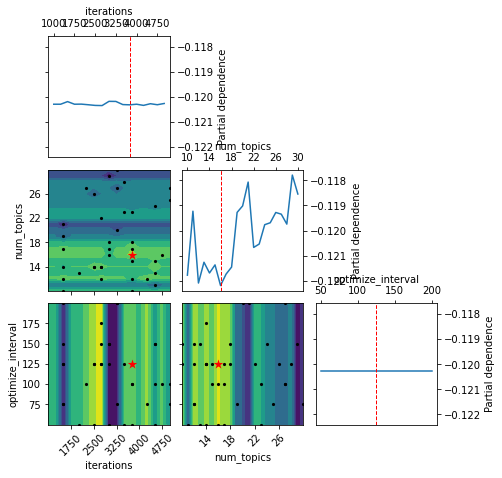

In [49]:
import matplotlib.pyplot as plt

_ = plot_objective(opt.optimizer_results_[0],
                   dimensions=["iterations", "num_topics","optimize_interval"],
                   n_minimum_search=int(1e8))
plt.show()

In [30]:
opt.total_iterations

108